In [41]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [42]:
# Function to get driver information from Ergast API
def get_driver_data(driver_id):
    url = f"http://ergast.com/api/f1/drivers/{driver_id}.json"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        driver_info = data['MRData']['DriverTable']['Drivers'][0]
        return driver_info
    else:
        print("Error fetching data from Ergast API")
        return None

# Get data for Lewis Hamilton (driverId is "hamilton")
driver_id = "hamilton"
driver_data = get_driver_data(driver_id)

# Display the data in a Pandas DataFrame
if driver_data:
    df = pd.DataFrame([driver_data])
    display(df[['driverId', 'permanentNumber', 'givenName', 'familyName', 'dateOfBirth', 'nationality']])
else:
    print("No data available for Lewis Hamilton")


,driverId,permanentNumber,givenName,familyName,dateOfBirth,nationality
0,hamilton,44,Lewis,Hamilton,1985-01-07,British


In [43]:
# Function to get lap times for the 2024 Singapore GP practice session
def get_singapore_gp_practice_lap_times():
    url = "http://ergast.com/api/f1/2024/16/laps.json"  # 16th round is the Singapore GP in 2024
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        laps_data = data['MRData']['RaceTable']['Races'][0]['Laps']
        
        all_lap_times = []
        for lap in laps_data:
            for timing in lap['Timings']:
                all_lap_times.append({
                    'lap': lap['number'],
                    'driverId': timing['driverId'],
                    'position': timing['position'],
                    'time': timing['time']
                })
        
        df_lap_times = pd.DataFrame(all_lap_times)
        return df_lap_times
    else:
        print("Error fetching lap times from Ergast API")
        return None

# Fetch the lap times data and display it
lap_times_df = get_singapore_gp_practice_lap_times()

if lap_times_df is not None:
    display(lap_times_df.head())


,lap,driverId,position,time
0,1,piastri,1,1:27.623
1,1,leclerc,2,1:28.179
2,1,norris,3,1:28.971
3,1,sainz,4,1:29.345
4,1,hamilton,5,1:29.674


In [44]:
# Function to convert lap times in 'mm:ss.sss' format to total seconds
def convert_lap_time_to_seconds(lap_time_str):
    minutes, seconds = lap_time_str.split(':')
    return int(minutes) * 60 + float(seconds)

# Convert lap times from the dataframe to seconds
lap_times_df['time_in_seconds'] = lap_times_df['time'].apply(convert_lap_time_to_seconds)


In [45]:

# Function to get all teams and their corresponding drivers for 2023
def get_teams_and_drivers_2023():
    url = "http://ergast.com/api/f1/2023/constructors.json"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        constructors = data['MRData']['ConstructorTable']['Constructors']
        
        teams_drivers = []
        for constructor in constructors:
            constructor_id = constructor['constructorId']
            constructor_name = constructor['name']
            
            # Fetch drivers for each constructor
            drivers_url = f"http://ergast.com/api/f1/2023/constructors/{constructor_id}/drivers.json"
            drivers_response = requests.get(drivers_url)
            
            if drivers_response.status_code == 200:
                drivers_data = drivers_response.json()
                drivers = drivers_data['MRData']['DriverTable']['Drivers']
                
                for driver in drivers:
                    teams_drivers.append({
                        'team': constructor_name,
                        'driverId': driver['driverId'],
                        'givenName': driver['givenName'],
                        'familyName': driver['familyName']
                    })
            else:
                print(f"Error fetching drivers for constructor {constructor_id}")
        
        df_teams_drivers = pd.DataFrame(teams_drivers)
        return df_teams_drivers
    else:
        print("Error fetching constructors data from Ergast API")
        return None

# Fetch the teams and drivers data for 2023 and display it
teams_drivers_df = get_teams_and_drivers_2023()

if teams_drivers_df is not None:
    display(teams_drivers_df)

,team,driverId,givenName,familyName
0,Alfa Romeo,bottas,Valtteri,Bottas
1,Alfa Romeo,zhou,Guanyu,Zhou
2,AlphaTauri,de_vries,Nyck,de Vries
3,AlphaTauri,lawson,Liam,Lawson
4,AlphaTauri,ricciardo,Daniel,Ricciardo
5,AlphaTauri,tsunoda,Yuki,Tsunoda
6,Alpine F1 Team,gasly,Pierre,Gasly
7,Alpine F1 Team,ocon,Esteban,Ocon
8,Aston Martin,alonso,Fernando,Alonso
9,Aston Martin,stroll,Lance,Stroll


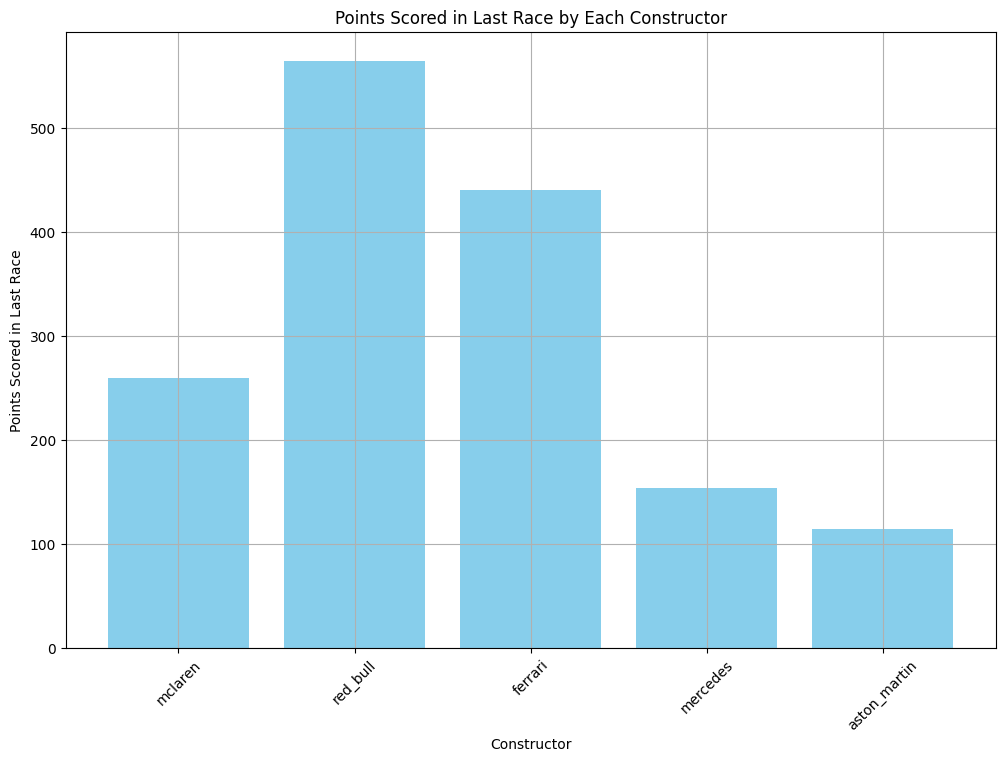

In [47]:
# Ensure top_5_constructors_df is defined
if 'top_5_constructors_df' not in globals():
    top_5_constructors_df = get_top_5_constructors_championship()

# Define the last_race_points column
top_5_constructors_df['last_race_points'] = top_5_constructors_df.apply(
    lambda row: get_constructor_points_last_5_races(row['constructorId']), axis=1
)

# Plot the points scored in the last race for all the teams
plt.figure(figsize=(12, 8))
plt.bar(top_5_constructors_df['constructorId'], top_5_constructors_df['last_race_points'], color='skyblue')

plt.xlabel('Constructor')
plt.ylabel('Points Scored in Last Race')
plt.title('Points Scored in Last Race by Each Constructor')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


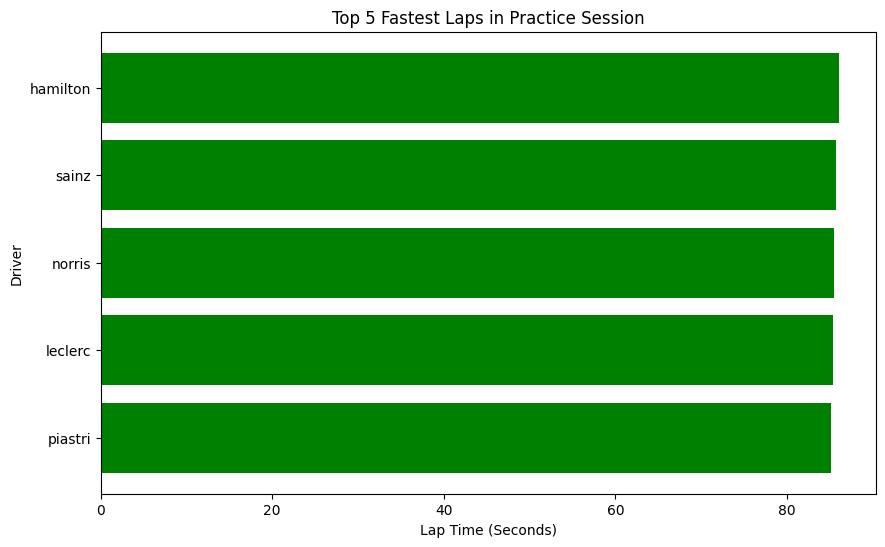

In [39]:
# Function to find and visualize the top 5 fastest laps
def plot_top_5_fastest_laps(lap_times_df):
    # Sort by the fastest lap times
    fastest_laps = lap_times_df.sort_values('time_in_seconds').head(5)
    
    # Plot the top 5 fastest laps
    plt.figure(figsize=(10, 6))
    plt.barh(fastest_laps['driverId'], fastest_laps['time_in_seconds'], color='green')
    plt.xlabel('Lap Time (Seconds)')
    plt.ylabel('Driver')
    plt.title('Top 5 Fastest Laps in Practice Session')
    plt.show()

# Plot the top 5 fastest laps
if lap_times_df is not None:
    plot_top_5_fastest_laps(lap_times_df)


,constructorId,points
0,mclaren,476
1,red_bull,456
2,ferrari,425
3,mercedes,309
4,aston_martin,82


ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

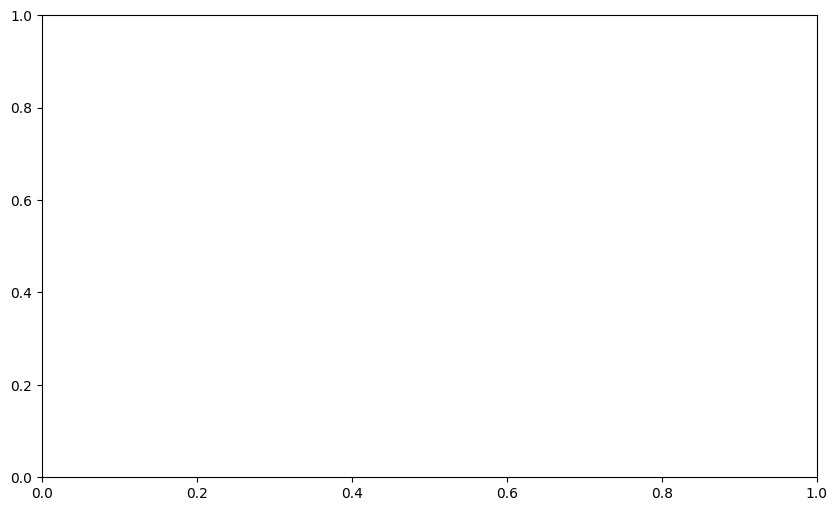

In [40]:
# Function to fetch Azerbaijan GP qualifying data and extract the top 5 drivers' sector times
def get_top_5_constructors_championship():
    url = "http://ergast.com/api/f1/current/constructorStandings.json"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        standings = data['MRData']['StandingsTable']['StandingsLists'][0]['ConstructorStandings']
        
        # Extract constructorId and points for the top 5 constructors
        top_5_constructors = []
        for i, constructor in enumerate(standings[:5]):
            top_5_constructors.append({
                'constructorId': constructor['Constructor']['constructorId'],
                'points': constructor['points']
            })
        
        df_top_5 = pd.DataFrame(top_5_constructors)
        return df_top_5
    else:
        print("Error fetching constructor standings from Ergast API")
        return None

# Fetch the top 5 constructors' championship data
top_5_constructors_df = get_top_5_constructors_championship()

if top_5_constructors_df is not None:
    display(top_5_constructors_df)

# Function to get points for the last 5 races for a given constructor
def get_constructor_points_last_5_races(constructor_id):
    points = []
    for round_number in range(1, 6):
        url = f"http://ergast.com/api/f1/current/{round_number}/constructorStandings.json"
        response = requests.get(url)
        
        if response.status_code == 200:
            data = response.json()
            standings = data['MRData']['StandingsTable']['StandingsLists'][0]['ConstructorStandings']
            for constructor in standings:
                if constructor['Constructor']['constructorId'] == constructor_id:
                    points.append(float(constructor['points']))
                    break
        else:
            points.append(0)
    
    return sum(points)  # Return the sum of points instead of the list

# Get points for the last 5 races for each of the top 5 constructors
for index, row in top_5_constructors_df.iterrows():
    constructor_id = row['constructorId']
    top_5_constructors_df.loc[index, 'last_5_races_points'] = get_constructor_points_last_5_races(constructor_id)

# Plot the points gained in the last 5 races for the top 5 constructors
plt.figure(figsize=(10, 6))
for index, row in top_5_constructors_df.iterrows():
    plt.plot(range(1, 6), row['last_5_races_points'], marker='o', label=row['constructorId'])

plt.xlabel('Race Number')
plt.ylabel('Points')
plt.title('Points Gained in Last 5 Races by Top 5 Constructors')
plt.legend()
plt.show()


In [9]:
# Function to convert times in 'mm:ss.sss' format to total seconds
def convert_time_to_seconds(time_str):
    if pd.isna(time_str):
        return None  # Handle missing times
    minutes, seconds = time_str.split(':')
    return int(minutes) * 60 + float(seconds)

# Convert Q3 and sector times to seconds
# Convert Q3 and sector times to seconds, replacing None with 0
azerbaijan_qualifying_df['sector1_seconds'] = azerbaijan_qualifying_df['sector1_time'].apply(convert_time_to_seconds)
azerbaijan_qualifying_df['sector2_seconds'] = azerbaijan_qualifying_df['sector2_time'].apply(convert_time_to_seconds)
azerbaijan_qualifying_df['sector3_seconds'] = azerbaijan_qualifying_df['sector3_time'].apply(convert_time_to_seconds)

C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_4680\29197577.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sector1_seconds'] = df['sector1_seconds'].fillna(0)
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_4680\29197577.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sector2_seconds'] = df['sector2_seconds'].fillna(0)
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_4680\29197577.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=Fa

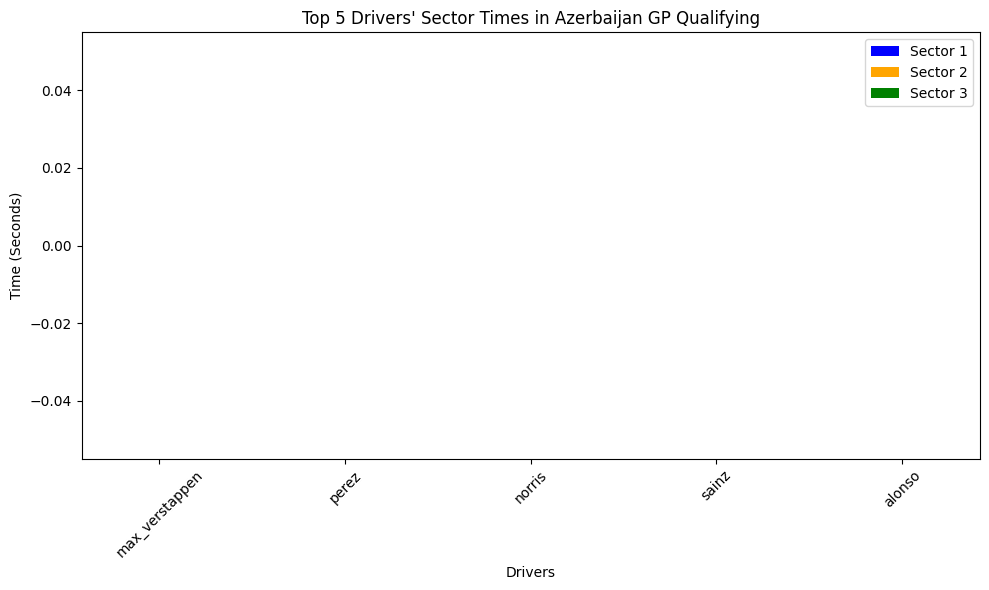

In [11]:
# Function to plot sector times of top 5 drivers in a stacked bar chart
def plot_top_5_drivers_sector_times(df):
    # Replace None with 0 in sector times
    df['sector1_seconds'] = df['sector1_seconds'].fillna(0)
    df['sector2_seconds'] = df['sector2_seconds'].fillna(0)
    df['sector3_seconds'] = df['sector3_seconds'].fillna(0)
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define the bar positions for each driver
    driver_ids = df['driverId']
    bar_positions = np.arange(len(driver_ids))
    
    # Plot the stacked bar chart
    bar_width = 0.4
    
    ax.bar(bar_positions, df['sector1_seconds'], bar_width, label='Sector 1', color='blue')
    ax.bar(bar_positions, df['sector2_seconds'], bar_width, bottom=df['sector1_seconds'], label='Sector 2', color='orange')
    ax.bar(bar_positions, df['sector3_seconds'], bar_width, 
           bottom=df['sector1_seconds'] + df['sector2_seconds'], label='Sector 3', color='green')
    
    # Add labels and title
    ax.set_xlabel('Drivers')
    ax.set_ylabel('Time (Seconds)')
    ax.set_title('Top 5 Drivers\' Sector Times in Azerbaijan GP Qualifying')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(driver_ids, rotation=45)
    ax.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot the sector times for the top 5 drivers
if azerbaijan_qualifying_df is not None:
    plot_top_5_drivers_sector_times(azerbaijan_qualifying_df)